===> Loading datasets
===> Training model
Epoch: [0]	Train	Loss 0.3582	AUC 0.5746	Valid	Loss 0.3651	AUC 0.6447
Epoch: [1]	Train	Loss 0.3265	AUC 0.6627	Valid	Loss 0.3551	AUC 0.6792
Epoch: [2]	Train	Loss 0.3197	AUC 0.6906	Valid	Loss 0.3443	AUC 0.6971
Epoch: [3]	Train	Loss 0.3032	AUC 0.7404	Valid	Loss 0.3422	AUC 0.7199
Epoch: [4]	Train	Loss 0.3043	AUC 0.7376	Valid	Loss 0.3369	AUC 0.7334
Epoch: [5]	Train	Loss 0.2962	AUC 0.7601	Valid	Loss 0.3295	AUC 0.7493
Epoch: [6]	Train	Loss 0.2965	AUC 0.7620	Valid	Loss 0.3281	AUC 0.7534
Epoch: [7]	Train	Loss 0.2922	AUC 0.7695	Valid	Loss 0.3461	AUC 0.7462
Epoch: [8]	Train	Loss 0.2928	AUC 0.7691	Valid	Loss 0.3326	AUC 0.7582
Epoch: [9]	Train	Loss 0.2920	AUC 0.7697	Valid	Loss 0.3525	AUC 0.7473
Epoch: [10]	Train	Loss 0.2879	AUC 0.7837	Valid	Loss 0.3380	AUC 0.7514
Epoch: [11]	Train	Loss 0.2874	AUC 0.7835	Valid	Loss 0.3283	AUC 0.7531
Epoch: [12]	Train	Loss 0.2838	AUC 0.7874	Valid	Loss 0.3235	AUC 0.7724
Epoch: [13]	Train	Loss 0.2862	AUC 0.7883	Valid	Loss 0.3246

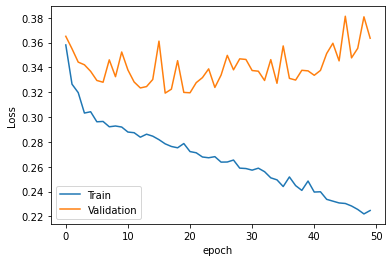

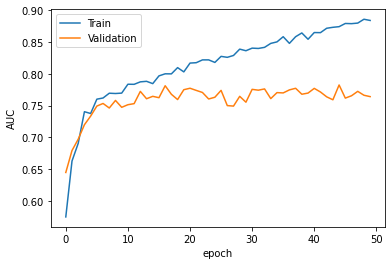

In [1]:
%load_ext autoreload
%autoreload 2

# borrowed gatech cse6250 hw5 template

import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from Python.rnn_data import etl_rnn, VisitSequenceWithLabelDataset, seq_collate_fn
from Python.rnn_model import RNN, plot_learning_curves, train, evaluate

NUM_EPOCHS = 50
BATCH_SIZE = 32
USE_CUDA = True
NUM_WORKERS = 8
DATAPATH = "Data"
LR = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")
torch.manual_seed(42)
if device.type == "cuda":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data loading
print('===> Loading datasets')

static_all, sequence_all = etl_rnn(DATAPATH)
y_train, y_test = train_test_split(static_all[['sepsis']], test_size=0.2, random_state=42)
seq_train = y_train.join(sequence_all).drop(columns=['sepsis'])
scaler = MinMaxScaler()
scaled_seq_train = scaler.fit_transform(seq_train)
scaled_seq_train = pd.DataFrame(scaled_seq_train, index=seq_train.index, columns=seq_train.columns)
seq_test = y_test.join(sequence_all).drop(columns=['sepsis'])
scaled_seq_test = scaler.transform(seq_test)
scaled_seq_test = pd.DataFrame(scaled_seq_test, index=seq_test.index, columns=seq_test.columns)
train_dataset = VisitSequenceWithLabelDataset(scaled_seq_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=seq_collate_fn, num_workers=NUM_WORKERS)
valid_dataset = VisitSequenceWithLabelDataset(scaled_seq_test, y_test)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=seq_collate_fn, num_workers=NUM_WORKERS)

model = RNN(seq_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

model.to(device)
criterion.to(device)

best_val_auc = 0.0
best_epoch = 0
train_losses, train_aucs = [], []
valid_losses, valid_aucs = [], []

print('===> Training model')
for epoch in range(NUM_EPOCHS):
    train_loss, train_auc = train(model, device, train_loader, criterion, optimizer, epoch)
    valid_loss, valid_auc = evaluate(model, device, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)
    
    print(f'Epoch: [{epoch}]\t'
          'Train\t'
          f'Loss {train_loss:.4f}\t'
          f'AUC {train_auc:.4f}\t'
          'Valid\t'
          f'Loss {valid_loss:.4f}\t'
          f'AUC {valid_auc:.4f}')
    
    is_best = valid_auc > best_val_auc
    if is_best:
        best_val_auc = valid_auc
        best_epoch = epoch
        torch.save(model, os.path.join("./output", "RNN.pth"), _use_new_zipfile_serialization=False)

best_model = torch.load(os.path.join("./output", "RNN.pth"))
plot_learning_curves(train_losses, valid_losses, train_aucs, valid_aucs)
print(f"best_val_auc at epoch {best_epoch}: {best_val_auc}")